## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt)

    # Check if the key exists in the saved results
    if key in all_results:
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_hmq_sep.pkl", "rb") as file:
    all_results = pickle.load(file)

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
#Trying to see how I can speed up the HMQ code a bit
#Standard approach: Running it a lower therhold, 1e-4 error, gives 1m.30s
#With EJs, gives 1m24s, basically the same damn
#Trying a bunch of paraller=True gives 1m11! Nice!
#Tring basically everything on parallel... puts us back to 1m24. damn

#Getting rid of the init and recaching phase now by starting the init part in a separate section. So new timings:
#most stuff parallelized gives 1m6.6s
#everything parallelized 1m15.6s. damn
#dropping those paprallels and adding fastmath 1m19.1s, dude fastmath is shit

In [5]:
from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)

In [6]:
# HMQ
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']


#(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()

#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 1d, C), array(int32, 5d, C))
 
There are 22 candidate implementations:
[1m    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float64, 1d, C), array(int32, 5d, C))':[0m
[1m     No match.[0m
[1m    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 211.
      With argument(s): '(array(float64, 1d, C), array(int32, 5d, C))':[0m
[1m     Rejected as the implementation raised a specific error:
       NumbaTypeError: [1mMulti-dimensional indices are not supported.[0m[0m
  raised from c:\Programs\Python 3.11\Lib\site-packages\numba\core\typing\arraydecl.py:91
[0m
[0m[1mDuring: typing of intrinsic-call at c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py (283)[0m
[1m
File "Multiworker_Contract_hire_hmq.py", line 283:[0m
[1mdef solve_everything(Ji,W1i,EW1i,w_grid,grid,sum_size,fun_prod,prod_nd,deriv_eps,inv_utility_1d,beta,pc,pc_d, rho_grid, N_grid, N_grid1, rho_star, sep_star, n1, num_z, num_n, n_bar, num_v, num_q):
    <source elided>
    Wderiv=np.zeros_like(Ji)
[1m    Ji3 = Ji + N_grid1[grid[2]]*rho_grid[ax,ax,ax,:,ax]*W1i[...,1] #This is the full rho
[0m    [1m^[0m[0m


In [5]:
# HMQ Separations

results = get_results_for_p(p,all_results)
if results is None:
    mwc_hmq_sd_J = objects['mwc_hmq_sd_J']
    mwc_hmq_sd_W = objects['mwc_hmq_sd_W']
else:
    mwc_hmq_sd_J = results['Ji']
    mwc_hmq_sd_W = results['W1i']

(mwc_hmq_sd_J,mwc_hmq_sd_W,mwc_hmq_sd_Wstar,mwc_hmq_sd_sep,mwc_hmq_sd_n0,mwc_hmq_sd_n1)=mwc_hmq.J_sep_dir()

objects['mwc_hmq_sd_J'] = mwc_hmq_sd_J
objects['mwc_hmq_sd_W'] = mwc_hmq_sd_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

No results found for p = (1, 100, 5, 4, 6, 0.5, 0.9, 90.0, 0.2, 0.25)
Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
wage_jun 0.0007973147805850004
wage jun no sep 0.0007973147805850004
Errors: 0.3484481779937802 3.262795820483182 1
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
wage_jun 0.00046364406894772116
wage jun no sep 0.00046364406894772116
EJinv -132.27583077674052
EJderiv -91.6607335477445
EJinv diff 1j 2s: 0.7536258154056186
EJinv diff 1 sen: 0.8656084407462535
EJinv diff 2 sen: 0.5965667323721796


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1141: RuntimeWarning: invalid value encountered in divide
  Ifire = ( (-EJderiv0-rho_star*(self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]])*pc_star*EWderiv0) + RhoderivQ0 * q0 / (self.N_grid[self.grid[1]]+self.N_grid[self.grid[2]]) - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(EW1_star + re_star)) > 0) & (self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]] <= self.p.n_bar) & (-(EJderiv1+rho_star*self.N_grid1[self.grid[2]]*pc_star*EWderiv1)*pc_star - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(0.5 * EUi + 0.5 * (EW1_star + re_star))) + RhoderivQ1 * q1 / (self.N_grid[self.grid[1]] * self.p.q_0+self.N_grid1[self.grid[2]]) < 0 )
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1157: RuntimeWarning: invalid value encountered in divide
  Icompletefire = ((-EJderiv0-rho_star*(self.N_grid[self.

q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 1.8413682887552474
wage_jun 0.0005488342367789857
wage jun no sep 0.0003079242345286685
sep borders 0.0 0.5
EJinv -120.14866469486395
EJderiv -89.09922132692033
EJinv diff 1j 2s: 1.811647151520204
EJinv diff 1 sen: 0.8348257924779559
EJinv diff 2 sen: 0.7573758598562573
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 1.815073273864218
wage_jun 0.00035176992201584067
wage jun no sep 0.00022228368925109843
sep borders 0.0 0.5
EJinv -108.30688937049067
EJderiv -100.86013032476069
EJinv diff 1j 2s: 0.12021805977841676
EJinv diff 1 sen: 0.8496781210911228
EJinv diff 2 sen: 1.2976089209007085
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 1.7876086592365938
wage_jun 0.00024811105300103913
wage jun no sep 0.0001699041524367492
sep borders 0.0 0.5
EJinv -105.38296849935821
EJderiv -95.91175459237421
EJinv diff 1j 2s: 0.11946515130164372
EJinv diff 1 sen: 0.8508618338731871
EJinv diff 2 sen: 5.5881441931379525
q_star [1. 1. 1. 1. 1. 1.]
n0_star bord

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1141: RuntimeWarning: invalid value encountered in multiply
  Ifire = ( (-EJderiv0-rho_star*(self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]])*pc_star*EWderiv0) + RhoderivQ0 * q0 / (self.N_grid[self.grid[1]]+self.N_grid[self.grid[2]]) - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(EW1_star + re_star)) > 0) & (self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]] <= self.p.n_bar) & (-(EJderiv1+rho_star*self.N_grid1[self.grid[2]]*pc_star*EWderiv1)*pc_star - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(0.5 * EUi + 0.5 * (EW1_star + re_star))) + RhoderivQ1 * q1 / (self.N_grid[self.grid[1]] * self.p.q_0+self.N_grid1[self.grid[2]]) < 0 )
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1157: RuntimeWarning: invalid value encountered in multiply
  Icompletefire = ((-EJderiv0-rho_star*(self.N_grid[s

q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 1.2353475635001905
wage_jun 6.581243713523662e-05
wage jun no sep 5.6172776499130535e-05
sep borders 0.0 0.5
EJinv -15.2386351664155
EJderiv -8.953229163607432
EJinv diff 1j 2s: 5.207355839825814
EJinv diff 1 sen: 0.6870773657044523
EJinv diff 2 sen: 0.617380249336806
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 1.1085238926883225
wage_jun 5.882480516843367e-05
wage jun no sep 5.089316851544468e-05
sep borders 0.0 0.5
EJinv 0.9773886203939435
EJderiv 5.907350237321026
EJinv diff 1j 2s: 0.3983444042582023
EJinv diff 1 sen: 0.6609941413849418
EJinv diff 2 sen: 0.5768166876787247
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
wage_jun 5.313343020731919e-05
wage jun no sep 4.6510665513300597e-05
sep borders 0.0 0.5
EJinv 16.59576560343331
EJderiv 20.10371975491968
EJinv diff 1j 2s: 0.12189541079737742
EJinv diff 1 sen: 0.6312605943319101
EJinv diff 2 sen: 0.541554646863323
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
wage_jun 4.842

KeyboardInterrupt: 

In [ ]:
# Retrieve the objects
#mwch_J = objects['mwch_J']
#mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J()
#(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_sd_J,mwch_sd_W,mwch_sd_Wstar,mwch_sd_sep,mwch_sd_n0,mwch_sd_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

In [29]:
mwc_hmq.fun_prod*mwc_hmq.prod[0,0,1,0,5]

array([[[[[4.]]]]])

In [60]:
mwc_hmq_n0[0,0,1,0,5]

0.0

In [30]:
cc.fun_prod

array([4.])

In [10]:
mwch_J[0,0,1,:]-mwc_J[0,0,1,:]

array([11.69576689, 11.67509036, 11.7217097 , 11.70288169, 11.68499972,
       11.72158278, 11.70564638, 11.69076086, 11.71935227, 11.70632765,
       11.69443164, 11.71659857, 11.70640504, 11.6971046 , 11.71377188,
       11.70600327, 11.69892208, 11.69283696, 11.70486037, 11.69990413,
       11.69531808, 11.69161261, 11.69942998, 11.69640444, 11.67880007,
       11.68343452, 11.68276795, 11.68269717, 11.68268606, 11.68334302,
       11.68415274, 11.68561926, 11.68792001, 11.69027383, 11.69264052,
       11.69501536, 11.69739702, 11.69978499, 11.70217901, 11.70457893,
       11.70698473, 11.70939778, 11.71184205, 11.71433455, 11.71686724,
       11.71943391, 11.72202974, 11.72465087, 11.72729423, 11.72995734,
       11.73263808, 11.73533486, 11.73804755, 11.74078432, 11.7435518 ,
       11.74634718, 11.749168  , 11.75201216, 11.7548778 , 11.75776332,
       11.76066731, 11.76358852, 11.76652586, 11.76947846, 11.77244633,
       11.77543204, 11.77844018, 11.78147005, 11.78452043, 11.78

# Plots

In [ ]:
#Okay, so we've got some inconsistencies:
#CRS lower than everyone
#HMQ and and basic MWC (without allowing for hiring) are the same
#MWC with hiring is higher than the others (despite hiring being too costly)
#wtf?
#Trying mwch without a guess now

In [ ]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_hmq_W[...,5,:],mwc_hmq_J[...,5]/mwc_hmq.N_grid1[1],mwch_W,mwch_J/mwch.N_grid1[1],mwc_W,mwc_J,0)

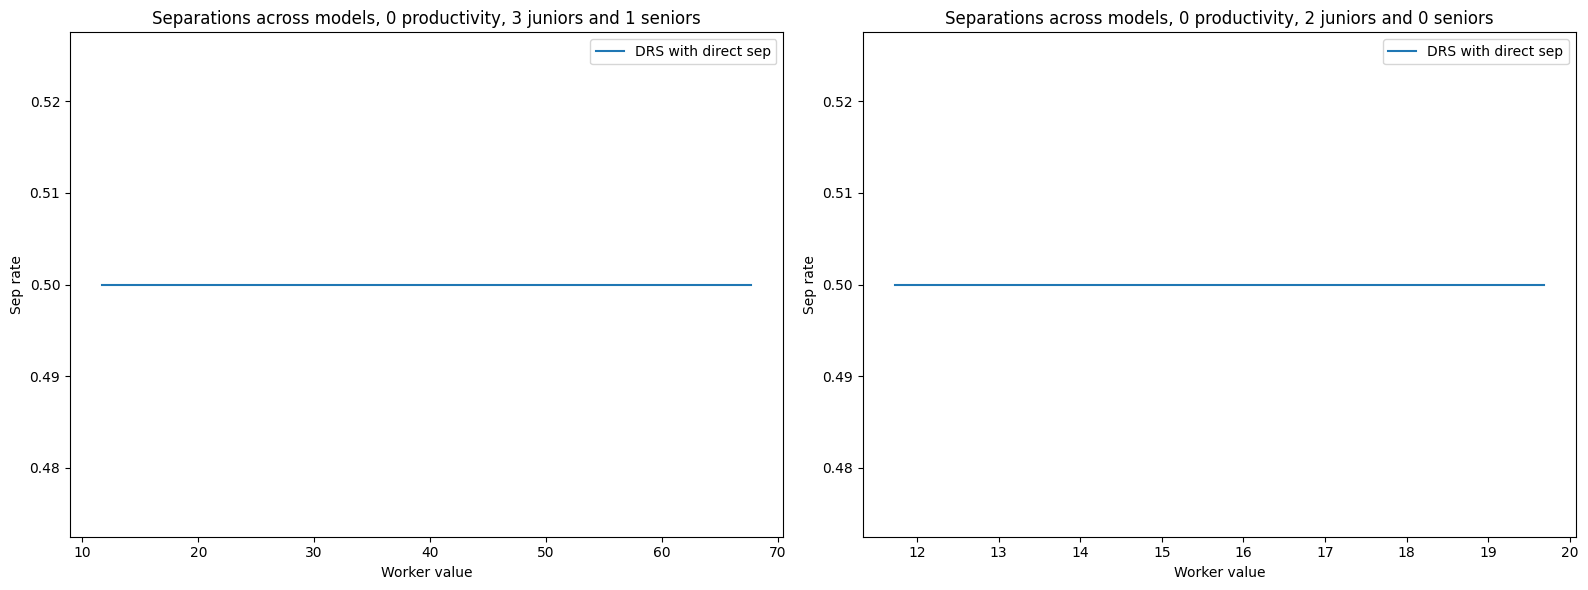

In [17]:
plts.sep(0,p.z_0-1,3,1,2,0,None,None,mwc_hmq_sd_W[...,1,:],mwc_hmq_sd_sep[...,1])

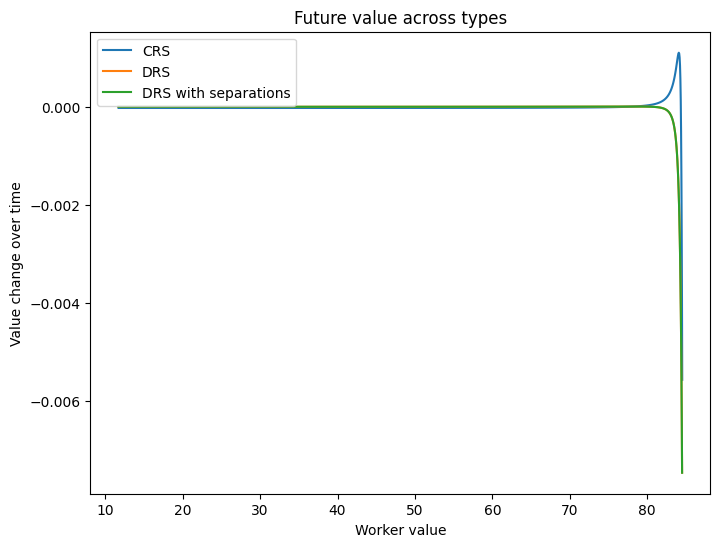

In [19]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_hmq_W[...,0,:],mwc_hmq_Wstar[...,0],mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_Wstar[...,0],mwc_sd_W,mwc_sd_Wstar,0)

In [1]:
plts.ValueComparison(3,1,3,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

NameError: name 'plts' is not defined

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations